# Convolutional Neural Network

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
# limit the memory ussage of GPU
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

print(tf.config.list_physical_devices('GPU'))

2024-11-11 09:07:22.655782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 09:07:22.668745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 09:07:22.672684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Total number of images: 23262


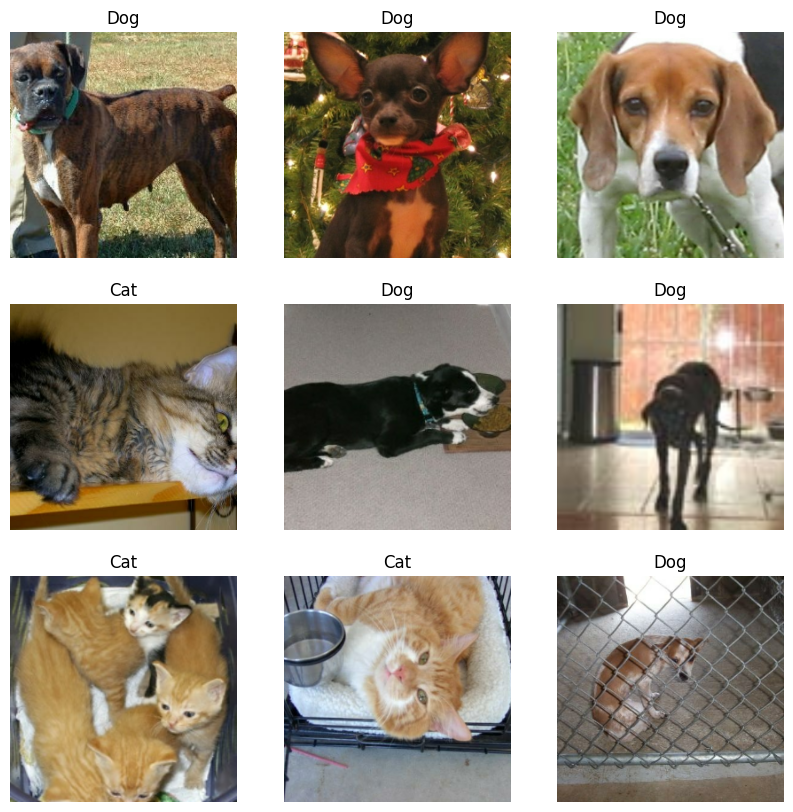

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256

# # Load cats_vs_dogs dataset
dataset = tfds.load('cats_vs_dogs', split='train', shuffle_files=False)

n_total = dataset.cardinality().numpy()
print(f"Total number of images: {n_total}")

@tf.function
def crop_to_square(image):
    # Get the dimensions of the image
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    
    # Determine the shorter side
    side_length = tf.minimum(height, width)
    
    # Calculate the offset to crop the image from the center
    offset_height = (height - side_length) // 2
    offset_width = (width - side_length) // 2
    
    # Crop the image to a square
    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, side_length, side_length)

    return cropped_image

# convert the images into the same size of IMAGE_SIZE x IMAGE_SIZE pixels
@tf.function
def preprocess(data):
    image = data['image']
    # crop image to square
    image = crop_to_square(image)
    # resize image to IMAGE_SIZE x IMAGE_SIZE pixels
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    # scale the channel values from [0,255] to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # return as a tuple
    return image, data['label'] 


# # Preprocess the data
dataset = dataset.map(preprocess)

# Display the first 9 images and labels from the dataset.
# The channels are now normalized to [0,1]
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Dog' if int(label) else 'Cat')
    plt.axis("off")

    # keep the first image for later use
    if i==0:
        first_image = image

# plit into training and validation sets
N_VAL = 5000
val_dataset = dataset.take(N_VAL)
train_dataset = dataset.skip(N_VAL)

# shuffle and batch the datasets
BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

train_dataset_size = n_total - N_VAL



In [3]:
EPOCHS = 10             # number of training epochs

N_BLOCKS = 7            # number of blocks of convolutional layers
N_LAYERS_PER_BLOCK = 2  # number of convolutional layers in each block
DIM_SCALE = 2           # DIM_SCALE*3 is added to the number of channels in each block
DROPOUT = 0.            # dropout rate

## create the input layer
inputShape = train_dataset.element_spec[0].shape  # this returns the input tensor shape including the batch dimension
print("Input shape: ", inputShape[1:])
input = tf.keras.layers.Input(shape=inputShape[1:]) # here we provide shape without the batch dimension
layer = input

## create the convolutional and max-pooling layers in a loop
for i in range(N_BLOCKS):    
    # scale up the number of channels to account for reduction of the spatial dimensions
    n_channels = int((i+1) * DIM_SCALE * 3)
    
    # block of n convolutional layers
    for j in range(N_LAYERS_PER_BLOCK):
        # convolutional layer: 3x3 kernel, ReLU activation
        layer = tf.keras.layers.Conv2D(n_channels, 3, activation='relu', padding='same')(layer) 
        if DROPOUT:
            layer = tf.keras.layers.Dropout(DROPOUT)(layer) # dropout layer: randomly sets 20% of the input units to 0

    # max-pooling that reduces the spatial dimensions of the image by a factor of 2
    layer = tf.keras.layers.MaxPooling2D()(layer) # max-pooling layer: reduces the spatial dimensions of the image by a factor of 2


## global max pooling layer
global_max_pooling = tf.keras.layers.GlobalMaxPooling2D()
layer = global_max_pooling(layer)

## final dense layer with sigmoid activation
output = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

## create the model
model = tf.keras.Model(inputs=input, outputs=output)

# cosine learning rate decay
initial_learning_rate = 0.001
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_learning_rate, 
    decay_steps=EPOCHS * train_dataset_size // BATCH_SIZE,
    alpha=0.01 * initial_learning_rate)

# compile the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate = learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()


Input shape:  (256, 256, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 6)    │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 12)   │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 12)   │         1,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 18)     │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 18)     │         2,934 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 24)     │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 30)     │         6,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 30)     │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 36)       │         9,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 36)       │        11,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 36)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 42)       │        13,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 42)       │        15,918 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 42)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 42)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 82,189 (321.05 KB)

 Trainable params: 82,189 (321.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1731314751.456182 1054158 service.cc:146] XLA service 0x7f0efc41db20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731314751.456217 1054158 service.cc:154]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9


  3/143 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - binary_accuracy: 0.5000 - loss: 0.6931  

I0000 00:00:1731314758.562653 1054158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - binary_accuracy: 0.5571 - loss: 0.6714 - val_binary_accuracy: 0.6864 - val_loss: 0.5866
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - binary_accuracy: 0.7202 - loss: 0.5526 - val_binary_accuracy: 0.7806 - val_loss: 0.4692
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - binary_accuracy: 0.7840 - loss: 0.4563 - val_binary_accuracy: 0.8002 - val_loss: 0.4327
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - binary_accuracy: 0.8142 - loss: 0.4101 - val_binary_accuracy: 0.8218 - val_loss: 0.3997
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - binary_accuracy: 0.8349 - loss: 0.3705 - val_binary_accuracy: 0.8316 - val_loss: 0.3769
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - binary_accuracy: 0.8485 - loss: 0.3429 - val_binary_accuracy: 0.8316 - val_loss: 0.3655
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - binary_accuracy: 0.8576 - loss: 0.3169 - val_binary_accuracy: 0.8496 - val_loss: 0.3447
Ep

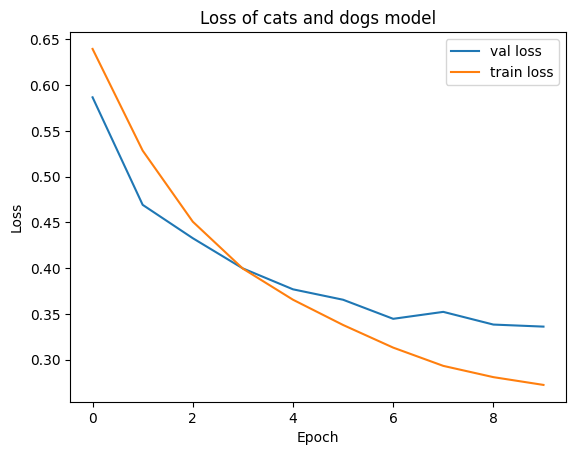

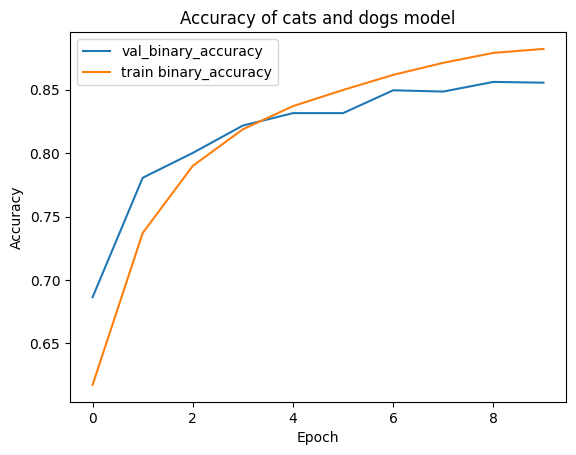

In [4]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

# evaluate the model
metrices_train = model.evaluate(train_dataset)
metrices_val = model.evaluate(val_dataset)

print("")
print("Overfitting check:")
print("")
for name, value_train, value_val in zip(model.metrics_names, metrices_train, metrices_val):
    print(name, "train:", value_train, "val:", value_val)


# plot the history
plt.figure("cats_dogs_history_loss")
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of cats and dogs model')
plt.legend()

plt.figure("cats_dogs_history_accuracy")
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['binary_accuracy'], label='train binary_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of cats and dogs model')
plt.legend()


In [ ]:
# The following function just picks data tensor from the (data, label) dataset
@ tf.function
def pick_only_data(data, label):
    return data

# draw signal and background separately
output_sig_val = model.predict(val_dataset.unbatch().filter(lambda x, label: label == 1).map(pick_only_data).batch(1024))
output_bkg_val = model.predict(val_dataset.unbatch().filter(lambda x, label: label == 0).map(pick_only_data).batch(1024))

plt.figure(figsize=(10, 4))
plt.hist(output_sig_val, histtype='step', bins=100, alpha=0.5, label='signal (val)', range=(0, 1))
plt.hist(output_bkg_val, histtype='step', bins=100, alpha=0.5, label='background (val)', range=(0, 1))

plt.xlabel('Output probability')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
## evaluation on random images for the internet

# load the image
# image_path = 'internet_images/download.jpeg'
# image_path = 'internet_images/how-much-does-a-cat-cost.jpeg.jpg'
# image_path = 'internet_images/Feral_cat_Virginia_crop.jpg'
# image_path = 'internet_images/cat-friends-706db6fc872a456ab9e168eface0a390.jpg'
# image_path = 'internet_images/beautiful-happy-reddish-havanese-puppy-dog-sitting-frontal-looking-camera-isolated-white-background-46868560.webp'
# image_path = 'internet_images/images.jpeg'
# image_path = 'internet_images/imrs.webp'
# image_path = 'internet_images/Science_Cats-84873657.webp'
# image_path = 'internet_images/Cat-facts-1240x650.jpg'
# image_path = 'internet_images/beautiful-smooth-haired-red-cat-lies-on-the-sofa-royalty-free-image-1678488026.jpg'
# image_path = 'internet_images/71425480007-getty-images-1498838344.webp'
# image_path = 'internet_images/86493379a7833889422fa9ec305eaae8.jpg'
# image_path = 'internet_images/how-to-draw-a-cat-for-kids-step-by-step.jpg'
# image_path = 'internet_images/cat-drawing-step-9-1.png'
# image_path = 'internet_images/MV5BOTA3NmU1NDMtYzcxMC00ZjI5LTllZWItYWI3MmZkNTE1ZTg0XkEyXkFqcGdeQW1hcmNtYW5u._V1_.jpg'
image_path = 'internet_images/challenger3-image3-rbsl-1200x800px-65b2a6e1154db.png'

image = tf.keras.utils.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), keep_aspect_ratio=True)
image_arr = tf.keras.utils.img_to_array(image)
image_arr = tf.cast(image_arr, tf.float32) / 255.0

# display the image
import matplotlib.pyplot as plt
plt.imshow(image)


# image batch
image_arr = tf.expand_dims(image_arr, 0)



# predict the image
prob = model.predict(image_arr)
print(f"Prob(dog|x) = {prob[0][0]}")
